In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d6d5439c88>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [10]:
from sqlalchemy import inspect
from datetime import datetime
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d6d5474c88>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0}

In [13]:
date_string = first_row_measurement.date
date_format = '%Y-%m-%d'
new_date = datetime.strptime(date_string, date_format).strftime("%Y-%m-%d")
print(date_string,new_date)

2010-01-01 2010-01-01


# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
most_recent = session.query(func.max(Measurement.date)).first() [0]                                                              


most_recent

'2017-08-23'

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
#last_12 = most_recent - datetime.timedelta(years = 1)
#last_12

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement).filter(Measurement.date > '2016-08-23').order_by(Measurement.date.desc()).all()
print(last_12_months[0])
print(last_12_months[0].date)
print(last_12_months[0].prcp)
print(last_12_months[0].id)
print(last_12_months[0].station)
print(last_12_months[0].tobs)

2017-08-23
0.0
2724
USC00519397
81.0


In [17]:
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').all()



In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
meas_df = pd.DataFrame(results, columns=['date', 'prcp'])
meas_df.set_index('date', inplace=True)
meas_df.head()
meas_df

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [19]:
prcp = meas_df['prcp']
prcp

date
2016-08-24    0.08
2016-08-25    0.08
2016-08-26    0.00
2016-08-27    0.00
2016-08-28    0.01
              ... 
2017-08-19    0.09
2017-08-20     NaN
2017-08-21    0.56
2017-08-22    0.50
2017-08-23    0.45
Name: prcp, Length: 2223, dtype: float64

In [20]:
meas_df.index


Index(['2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27', '2016-08-28',
       '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02',
       ...
       '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
       '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23'],
      dtype='object', name='date', length=2223)

In [21]:
meas_df = meas_df.dropna()
meas_df

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


In [22]:
# Sort the dataframe by date -- this was done with the query ORDER BY

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data

x_values = meas_df.index
y_values = meas_df['prcp']
x_values

Index(['2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27', '2016-08-28',
       '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02',
       ...
       '2017-08-10', '2017-08-12', '2017-08-14', '2017-08-15', '2017-08-16',
       '2017-08-17', '2017-08-19', '2017-08-21', '2017-08-22', '2017-08-23'],
      dtype='object', name='date', length=2015)

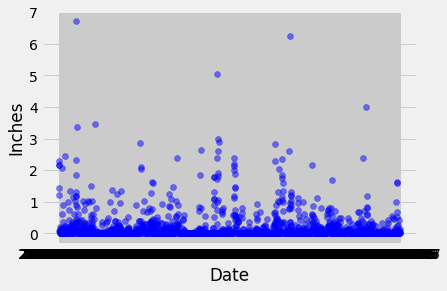

In [43]:
plt.scatter(x_values, y_values, marker='o', facecolor='blue', alpha=0.5)

plt.ylabel('Inches')
plt.xlabel('Date', rotation=0.30)

plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
meas_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [27]:
results = session.query(Station.id, Station.name, func.count(Station.id)).all()
results

[(1, 'WAIKIKI 717.2, HI US', 9)]

In [28]:
# Design a query to calculate the total number stations in the dataset
from sqlalchemy import distinct  #add to head

results = session.query(func.count(distinct(Station.station))).all()
results

[(9)]

In [29]:
results = session.query(Station.id, Station.station, Station.name).all()
results     #a list of tuples

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (4, 'USC00517948', 'PEARL CITY, HI US'),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [30]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

count_by_station = []   #gonna create a list of tuples
for row in results:
    #print(row[1])
    measurements = session.query(Measurement.station, func.count(distinct(Measurement.prcp))).filter(Measurement.station == row[1]).all()
    print(measurements)
    count_by_station.append(measurements[0])
 
#count_by_station
station_count_df = pd.DataFrame(count_by_station, columns = ['station', 'measurement_count'])
station_count_sorted_df = station_count_df.sort_values('measurement_count', ascending=False)
station_count_sorted_df

[('USC00519397', 98)]
[('USC00513117', 149)]
[('USC00514830', 115)]
[('USC00517948', 51)]
[('USC00518838', 76)]
[('USC00519523', 140)]
[('USC00519281', 194)]
[('USC00511918', 77)]
[('USC00516128', 260)]


,station,measurement_count
8,USC00516128,260
6,USC00519281,194
1,USC00513117,149
5,USC00519523,140
2,USC00514830,115
0,USC00519397,98
7,USC00511918,77
4,USC00518838,76
3,USC00517948,51


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Lowest precipitation for most active station is 'USC00516128'
results = session.query(func.min(Measurement.prcp)).filter(Measurement.station == 'USC00516128').all()
print(results[0][0])

0.0


In [32]:
# Highest precipitation for most active station 'USC00516128'
results = session.query(func.max(Measurement.prcp)).filter(Measurement.station == 'USC00516128').all()
print(results[0][0])

8.06


In [33]:
# Average precipitation from most active station 'USC00516128'
results = session.query(func.avg(Measurement.prcp)).filter(Measurement.station == 'USC00516128').\
    filter(Measurement.prcp != 'None').all()
print(results[0][0])
print(round(results[0][0],6))



0.4299879227053122
0.429988


In [45]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00516128').\
            filter(Measurement.date > '2016-08-23').order_by(Measurement.date.desc()).\
            filter(Measurement.tobs != 'None').all()
results

[('2017-08-23', 76.0),
 ('2017-08-22', 76.0),
 ('2017-08-21', 76.0),
 ('2017-08-20', 78.0),
 ('2017-08-19', 71.0),
 ('2017-08-18', 76.0),
 ('2017-08-17', 72.0),
 ('2017-08-16', 71.0),
 ('2017-08-15', 70.0),
 ('2017-08-14', 79.0),
 ('2017-08-13', 80.0),
 ('2017-08-12', 74.0),
 ('2017-08-11', 72.0),
 ('2017-08-10', 75.0),
 ('2017-08-09', 71.0),
 ('2017-08-08', 74.0),
 ('2017-08-07', 78.0),
 ('2017-08-06', 79.0),
 ('2017-08-05', 77.0),
 ('2017-08-03', 76.0),
 ('2017-08-02', 80.0),
 ('2017-08-01', 72.0),
 ('2017-07-31', 74.0),
 ('2017-07-30', 79.0),
 ('2017-07-29', 77.0),
 ('2017-07-28', 73.0),
 ('2017-07-27', 75.0),
 ('2017-07-26', 73.0),
 ('2017-07-25', 79.0),
 ('2017-07-24', 77.0),
 ('2017-07-23', 78.0),
 ('2017-07-22', 72.0),
 ('2017-07-21', 72.0),
 ('2017-07-20', 75.0),
 ('2017-07-19', 74.0),
 ('2017-07-18', 77.0),
 ('2017-07-17', 72.0),
 ('2017-07-16', 75.0),
 ('2017-07-15', 78.0),
 ('2017-07-14', 76.0),
 ('2017-07-13', 77.0),
 ('2017-07-12', 72.0),
 ('2017-07-11', 74.0),
 ('2017-07-

In [46]:
active_df = pd.DataFrame(results, columns = ['date', 'tobs'])

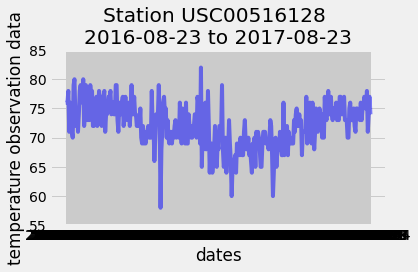

In [55]:
import matplotlib.pyplot as plt

x_data = active_df['date']
y_data = active_df['tobs']

fig, ax = plt.subplots(1,1)

# the following gets:  ValueError: `bins` must increase monotonically, when an array
# ax.hist(x_data, bins=['2016-08-01','2016-09-01','2016-10-01',
#                          '2016-11-01','2016-12-01','2017-01-01', 
#                          '2017-02-01','2017-03-01','2017-04-01',
#                          '2017-05-01','2017-06-01','2017-07-01',
#                          '2017-08-01','2017-09-01'])
ax.hist(x_data, bins=12, density=True)
#ax[1].hist(y_data, bin)
ax.set_title('Station USC00516128 \n2016-08-23 to 2017-08-23')
#ax.set_xticks(['2016-08-01','2016-11-01','2017-02-01','2017-05-01','2017-08-01'])
ax.plot(x_data, y_data, color='blue', alpha=0.5)
ax.set_xlabel('dates')
ax.set_ylabel('temperature observation data')
fig.tight_layout()
plt.ylim([55,85])
plt.show()

# Close session

In [56]:
# Close Session
session.close()